In [1]:
# Full ADWIN-based Concept Drift Detection and Evaluation on IoMT IDS Dataset (Enhanced Visualization) with HAT

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime
from river import compose, preprocessing, metrics, drift, tree
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pathlib import Path
import os

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load Dataset CICIoMT2024
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        try:
            df = pd.read_csv(file)
            category = file.parents[1].name
            attack = file.parent.name
            label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'
            df['category'] = category
            df['attack'] = attack
            df['class'] = label_class
            data.append(df)
        except Exception as e:
            print(f"[ERROR] Failed to read file {file}: {e}")
    return pd.concat(data, ignore_index=True)

train_root = Path('../../../../../Data/CICIoMT2024/train')
test_root = Path('../../../../../Data/CICIoMT2024/test')
df_train = load_dataset_from_structure(train_root)
df_test = load_dataset_from_structure(test_root)
df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
# Encode label (category level)
le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])

# Feature processing
X = df.drop(['class_encoded', 'category', 'attack', 'category'], axis=1, errors='ignore').select_dtypes(include=[np.number])
y = df['class_encoded']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_dicts = pd.DataFrame(X_scaled, columns=X.columns).to_dict(orient='records')
y_values = y.tolist()
dataset = list(zip(X_dicts, y_values))

In [4]:
# Define model using HAT
model = compose.Pipeline(
    ('scaler', preprocessing.StandardScaler()),
    ('classifier', tree.HoeffdingAdaptiveTreeClassifier())
)

# Metrics
metric_accuracy = metrics.Accuracy()
metric_precision = metrics.WeightedPrecision()
metric_recall = metrics.WeightedRecall()
metric_f1 = metrics.WeightedF1()

In [5]:
# Drift detector
drift_detector = drift.ADWIN()

# Logging
drift_events = []
metric_logs = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'instances': []}
processing_times, drift_time_per_instance, metrics_time_per_instance = [], [], []


In [6]:
# Streaming loop
start_time = time.time()
for i, (x, y_true) in enumerate(dataset):
    t_start = time.time()
    y_pred = model.predict_one(x)
    model.learn_one(x, y_true)

    t_metrics = time.time()
    metric_accuracy.update(y_true, y_pred)
    metric_precision.update(y_true, y_pred)
    metric_recall.update(y_true, y_pred)
    metric_f1.update(y_true, y_pred)
    t_metrics_done = time.time()

    metric_logs['accuracy'].append(metric_accuracy.get())
    metric_logs['precision'].append(metric_precision.get())
    metric_logs['recall'].append(metric_recall.get())
    metric_logs['f1_score'].append(metric_f1.get())
    metric_logs['instances'].append(i)

    drift_detector.update(y_pred == y_true)
    if drift_detector.drift_detected:
        print(f"Drift detected at instance {i}")
        drift_events.append(i)

    processing_times.append(time.time() - t_start)
    metrics_time_per_instance.append(t_metrics_done - t_metrics)
    drift_time_per_instance.append(time.time() - t_metrics_done)

end_time = time.time()
total_execution_time = end_time - start_time
metrics_time_total = sum(metrics_time_per_instance)
drift_time_total = sum(drift_time_per_instance)

print(f"\nTotal execution time: {total_execution_time:.2f} seconds")
print(f"Time spent on drift detection: {drift_time_total:.2f} seconds")
print(f"Time spent updating metrics: {metrics_time_total:.2f} seconds")
print(f"Total drifts detected: {len(drift_events)}")

Drift detected at instance 193439
Drift detected at instance 196223
Drift detected at instance 7161183
Drift detected at instance 7165695
Drift detected at instance 7204223
Drift detected at instance 7412319
Drift detected at instance 7576159
Drift detected at instance 7590495
Drift detected at instance 7613535
Drift detected at instance 7630943
Drift detected at instance 7726847
Drift detected at instance 8152831
Drift detected at instance 8198911
Drift detected at instance 8233343
Drift detected at instance 8263039
Drift detected at instance 8273279
Drift detected at instance 8379231
Drift detected at instance 8706911
Drift detected at instance 8745599
Drift detected at instance 8747455
Drift detected at instance 8752447

Total execution time: 5583.23 seconds
Time spent on drift detection: 219.24 seconds
Time spent updating metrics: 43.80 seconds
Total drifts detected: 21


In [7]:
# Drift event table
drift_df = pd.DataFrame({
    'Drift Index': list(range(1, len(drift_events) + 1)),
    'Instance': drift_events,
    'Timestamp': [datetime.fromtimestamp(start_time + sum(processing_times[:i])).strftime('%H:%M:%S') for i in drift_events]
})
print("\nDrift Events Table:")
print(drift_df.to_string(index=False))



Drift Events Table:
 Drift Index  Instance Timestamp
           1    193439  18:52:48
           2    196223  18:52:49
           3   7161183  20:05:35
           4   7165695  20:05:38
           5   7204223  20:06:06
           6   7412319  20:08:34
           7   7576159  20:10:30
           8   7590495  20:10:40
           9   7613535  20:10:56
          10   7630943  20:11:08
          11   7726847  20:12:16
          12   8152831  20:17:19
          13   8198911  20:17:52
          14   8233343  20:18:16
          15   8263039  20:18:38
          16   8273279  20:18:45
          17   8379231  20:20:00
          18   8706911  20:23:51
          19   8745599  20:24:18
          20   8747455  20:24:20
          21   8752447  20:24:23


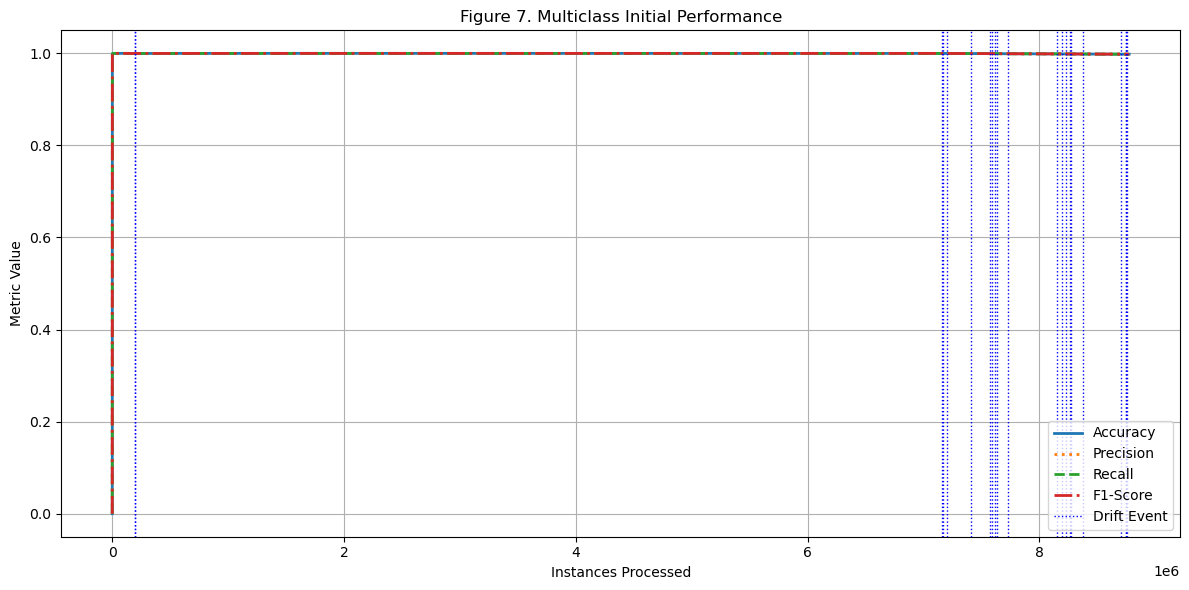

In [8]:
# Visualize Multiclass Initial Performance (Figure 7)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(metric_logs['instances'], metric_logs['accuracy'], label='Accuracy', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['precision'], label='Precision', linestyle=':', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['recall'], label='Recall', linestyle='--', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['f1_score'], label='F1-Score', linestyle='-.', linewidth=2)

# Add drift event lines
for idx, drift in enumerate(drift_events):
    if metric_logs['instances'][0] <= drift <= metric_logs['instances'][-1]:
        plt.axvline(x=drift, color='blue', linestyle=':', linewidth=1, label='Drift Event' if idx == 0 else None)

plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
plt.title('Figure 7. Multiclass Initial Performance')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

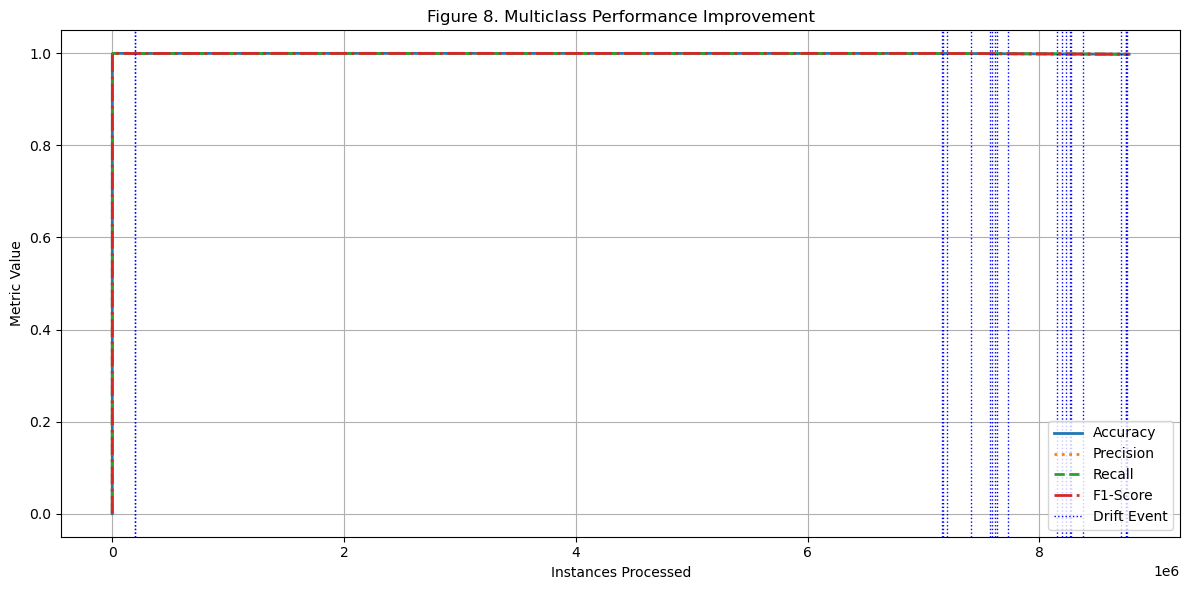

In [9]:
# Visualize Multiclass Performance Improvement (Figure 8)
plt.figure(figsize=(12, 6))
plt.plot(metric_logs['instances'], metric_logs['accuracy'], label='Accuracy', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['precision'], label='Precision', linestyle=':', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['recall'], label='Recall', linestyle='--', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['f1_score'], label='F1-Score', linestyle='-.', linewidth=2)

# Add drift event lines
for idx, drift in enumerate(drift_events):
    if metric_logs['instances'][0] <= drift <= metric_logs['instances'][-1]:
        plt.axvline(x=drift, color='blue', linestyle=':', linewidth=1, label='Drift Event' if idx == 0 else None)

plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
plt.title('Figure 8. Multiclass Performance Improvement')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

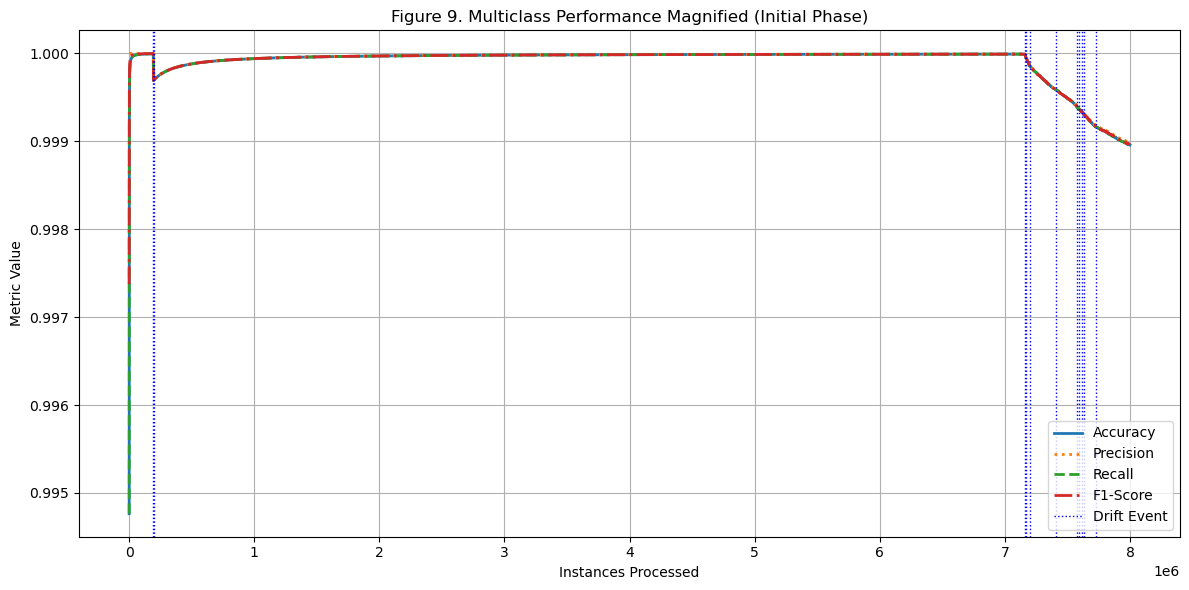

In [10]:
# Visualize Multiclass Performance Magnified (Figure 9)
plt.figure(figsize=(12, 6))
zoom_start = 190
zoom_end = 8000000
x_vals = metric_logs['instances'][zoom_start:zoom_end]
plt.plot(x_vals, metric_logs['accuracy'][zoom_start:zoom_end], label='Accuracy', linewidth=2)
plt.plot(x_vals, metric_logs['precision'][zoom_start:zoom_end], label='Precision', linestyle=':', linewidth=2)
plt.plot(x_vals, metric_logs['recall'][zoom_start:zoom_end], label='Recall', linestyle='--', linewidth=2)
plt.plot(x_vals, metric_logs['f1_score'][zoom_start:zoom_end], label='F1-Score', linestyle='-.', linewidth=2)

# Add drift event lines within zoom range
for idx, drift in enumerate(drift_events):
    if x_vals[0] <= drift <= x_vals[-1]:
        plt.axvline(x=drift, color='blue', linestyle=':', linewidth=1, label='Drift Event' if idx == 0 else None)

plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
plt.title('Figure 9. Multiclass Performance Magnified (Initial Phase)')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

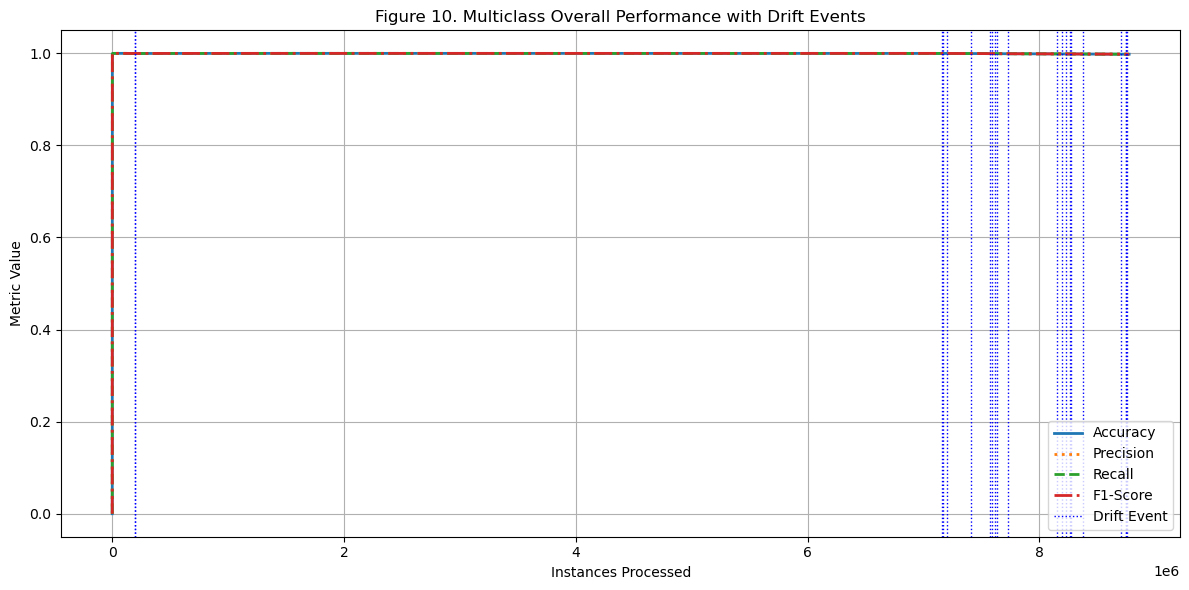

In [11]:
# Visualize Multiclass Overall Performance with Drift Events (Figure 10)
plt.figure(figsize=(12, 6))
plt.plot(metric_logs['instances'], metric_logs['accuracy'], label='Accuracy', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['precision'], label='Precision', linestyle=':', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['recall'], label='Recall', linestyle='--', linewidth=2)
plt.plot(metric_logs['instances'], metric_logs['f1_score'], label='F1-Score', linestyle='-.', linewidth=2)

# Add vertical lines for drift events
for idx, drift in enumerate(drift_events):
    if metric_logs['instances'][0] <= drift <= metric_logs['instances'][-1]:
        plt.axvline(x=drift, color='blue', linestyle=':', linewidth=1, label='Drift Event' if idx == 0 else None)

plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
plt.title('Figure 10. Multiclass Overall Performance with Drift Events')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


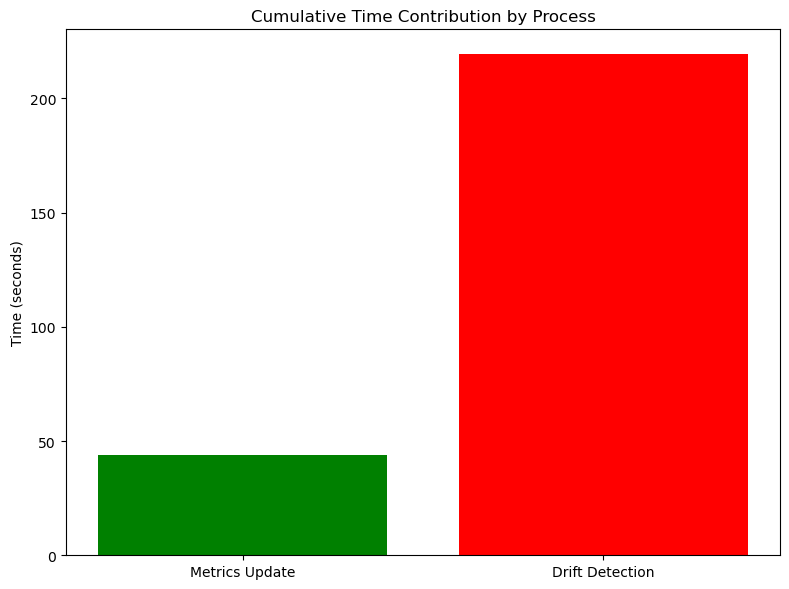

In [12]:
# Cumulative time plot
labels = ['Metrics Update', 'Drift Detection']
time_values = [metrics_time_total, drift_time_total]

plt.figure(figsize=(8, 6))
plt.bar(labels, time_values, color=['green', 'red'])
plt.title('Cumulative Time Contribution by Process')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.savefig('cumulative_time_contribution.png', dpi=300)
plt.show()

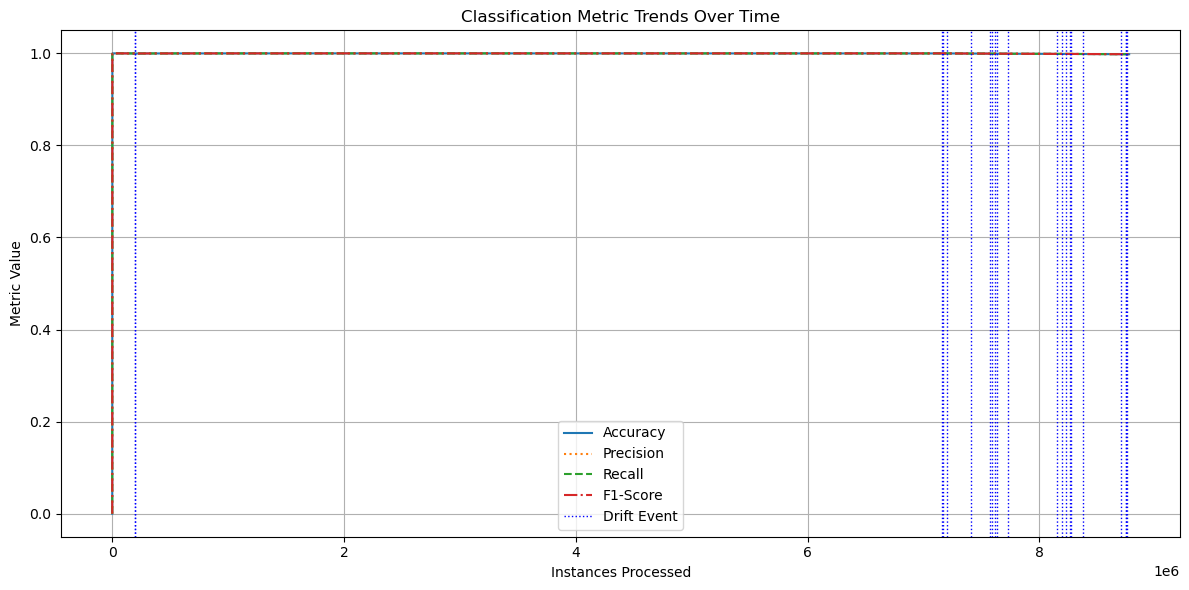

In [13]:
# Plot metric logs
instances = list(range(1, len(metric_logs['accuracy']) + 1))
plt.figure(figsize=(12, 6))
plt.plot(instances, metric_logs['accuracy'], label='Accuracy')
plt.plot(instances, metric_logs['precision'], label='Precision', linestyle=':')
plt.plot(instances, metric_logs['recall'], label='Recall', linestyle='--')
plt.plot(instances, metric_logs['f1_score'], label='F1-Score', linestyle='-.')
for i, drift in enumerate(drift_events):
    plt.axvline(x=drift, color='blue', linestyle=':', linewidth=1, label='Drift Event' if i == 0 else "")
plt.xlabel('Instances Processed')
plt.ylabel('Metric Value')
plt.title('Classification Metric Trends Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('metrics_drift_hat_category.png', dpi=300)
plt.show()

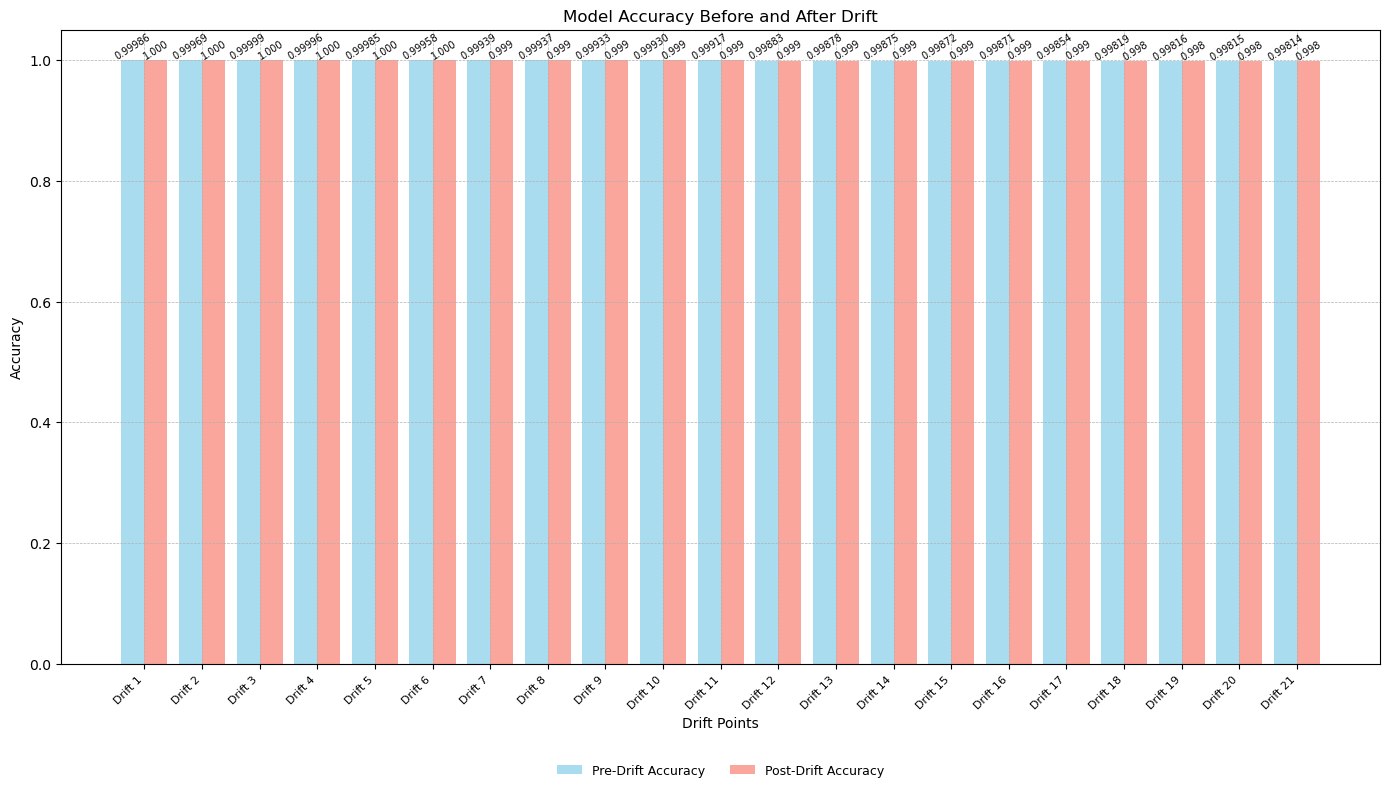

In [14]:
# Accuracy before and after drift
if drift_events:
    pre_drift_acc = [metric_logs['accuracy'][i - 1] for i in drift_events if i > 0]
    post_drift_acc = [metric_logs['accuracy'][i] for i in drift_events if i < len(metric_logs['accuracy'])]
    drift_labels = [f"Drift {i+1}" for i in range(len(pre_drift_acc))]

    x = range(len(pre_drift_acc))
    bar_width = 0.4

    plt.figure(figsize=(14, 8))
    plt.bar(x, pre_drift_acc, width=bar_width, label='Pre-Drift Accuracy', alpha=0.7, color='skyblue')
    plt.bar([i + bar_width for i in x], post_drift_acc, width=bar_width, label='Post-Drift Accuracy', alpha=0.7, color='salmon')

    for i, (pre, post) in enumerate(zip(pre_drift_acc, post_drift_acc)):
        plt.text(i, pre + 0.002, f'{pre:.5f}', rotation=32, ha='center', fontsize=7)
        plt.text(i + bar_width, post + 0.002, f'{post:.3f}', rotation=32, ha='center', fontsize=7)

    plt.xticks([i + bar_width / 2 for i in x], drift_labels, rotation=45, ha='right', fontsize=8)
    plt.ylabel('Accuracy')
    plt.xlabel('Drift Points')
    plt.title('Model Accuracy Before and After Drift')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), ncol=2, fontsize=9, frameon=False)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('drift_accuracy_comparison_hat_category.png', dpi=300)
    plt.show()
else:
    print("No drift events detected, skipping pre/post drift comparison.")


In [15]:
# Final metrics
print(f"Final Accuracy: {metric_accuracy.get():.4f}")
print(f"Final Precision: {metric_precision.get():.4f}")
print(f"Final Recall: {metric_recall.get():.4f}")
print(f"Final F1-Score: {metric_f1.get():.4f}")

Final Accuracy: 0.9981
Final Precision: 0.9982
Final Recall: 0.9981
Final F1-Score: 0.9981
